# Wiener Predictor

## Imports

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import matplotlib.pyplot as plt
import numpy as np

## Training Set

In [2]:
# frequency domain CSI
csi_freq_domain = np.load('dataset/csi_freq_domain_train.npy')
csi_freq_domain = csi_freq_domain.reshape(csi_freq_domain.shape[0],csi_freq_domain.shape[1],csi_freq_domain.shape[2]*csi_freq_domain.shape[3],csi_freq_domain.shape[4])
# sample autocorrelation of CSI over antenna dimension
csi_freq_domain_outer_product = np.einsum('lbin, lbjn -> lbnij', csi_freq_domain, np.conj(csi_freq_domain))

# timestamps
timestamps_train = np.load('dataset/timestamps_train.npy')

# indices of samples used for training
training_indices = np.load('dataset/training_indices.npy')

## Determine Wiener Filter Coefficients

In [3]:
# set memory size and prediction horizon
k = 25 # l-k, ..., l
p = 15 # l + p

In [4]:
# compute temporal autocorrelation
temporal_autocorrelation = []
for d in range(0,p+k):
    temporal_autocorrelation.append(np.mean(csi_freq_domain_outer_product[training_indices[:,-1]] * np.conj(csi_freq_domain_outer_product[training_indices[:,-(d+1)]]), axis=0))

temporal_autocorrelation = np.asarray(temporal_autocorrelation)
temporal_autocorrelation = np.moveaxis(temporal_autocorrelation, 0, -1)
print(temporal_autocorrelation.shape)

(4, 32, 8, 8, 40)


In [5]:
# delta_k_p (shape: arrays, subcarriers, antennas, antennas, k)
delta_k_p = temporal_autocorrelation[...,p:p+k]

# T_k_0 (shape: arrays, subcarriers, antennas, antennas, k, k)
Delta_k_0 = [[(0 + abs(i - j)) for j in range(k)] for i in range(k)]
Delta_k_0 = temporal_autocorrelation[...,Delta_k_0]
T_k_0 = np.asarray(Delta_k_0)

# inverse of T_k_0 (shape: arrays, subcarriers, antennas, antennas, k, k)
T_k_0_inv = np.linalg.inv(T_k_0)

# Wiener filter coefficients (shape: arrays, subcarriers, antennas, antennas, k)
V_p = np.einsum('bnijd, bnijdk -> bnijk', delta_k_p, T_k_0_inv)
print(V_p.shape)

(4, 32, 8, 8, 25)


## Test Set

In [6]:
# frequency domain CSI
csi_freq_domain_test = np.load('dataset/csi_freq_domain_test.npy')
csi_freq_domain_test = csi_freq_domain_test.reshape(csi_freq_domain_test.shape[0],csi_freq_domain_test.shape[1],csi_freq_domain_test.shape[2]*csi_freq_domain_test.shape[3],csi_freq_domain_test.shape[4])
# outer product of CSI over antennas
csi_freq_domain_test_outer_product = np.einsum('lbin, lbjn -> lbnij', csi_freq_domain_test, np.conj(csi_freq_domain_test))

# channel chart positions
channel_chart_positions_test = np.load('results/channel_chart_positions_test.npy')

# timestamps
timestamps_test = np.load('dataset/timestamps_test.npy')

# indices of samples used for prediction
prediction_indices = np.load('dataset/prediction_indices.npy')

## Prediction on Test Set

In [7]:
true_cc_positions_test = []

true_csi_freq_domain_test = [] # Ground Truth
memory_csi_freq_domain_test = []
outdated_csi_freq_domain_test = [] # Baseline CSI for Channel Prediction

for i in range(prediction_indices.shape[0]):
    # index to predict l
    l = prediction_indices[i,-1]

    # previous indices at l-p,l-p-1,...,l-p-k+1
    if p == 0:
        previous_indices = prediction_indices[i,-p-k:]
    else:
        previous_indices = prediction_indices[i,-p-k:-p]
    
    # true cc position at l
    true_cc_positions_test.append(channel_chart_positions_test[l])

    # true csi at l
    true_csi_freq_domain_test.append(csi_freq_domain_test[l])
    # outdated csi at l-p
    outdated_csi_freq_domain_test.append(csi_freq_domain_test[l-p])
    # csi in memory
    memory_csi_freq_domain_test.append(csi_freq_domain_test[np.flip(previous_indices)])

true_cc_positions_test = np.asarray(true_cc_positions_test)

true_csi_freq_domain_test = np.asarray(true_csi_freq_domain_test)
outdated_csi_freq_domain_test = np.asarray(outdated_csi_freq_domain_test)
memory_csi_freq_domain_test = np.asarray(memory_csi_freq_domain_test)

# sample autocorrelations of CSI in memory over antenna dimension
memory_csi_freq_domain_test_outer_product = np.einsum('lkbin, lkbjn -> lbnijk', memory_csi_freq_domain_test, np.conj(memory_csi_freq_domain_test))

In [8]:
# predict sample autocorrelation of CSI
predicted_csi_freq_domain_test_wiener_outer_product = np.einsum('bnijk, lbnijk -> lbnij', V_p, memory_csi_freq_domain_test_outer_product)
print(predicted_csi_freq_domain_test_wiener_outer_product.shape)

# obtain CSI from sample autocorrelation
predicted_csi_freq_domain_test_wiener = np.zeros(predicted_csi_freq_domain_test_wiener_outer_product.shape[:4], dtype=np.csingle)

for l in range(predicted_csi_freq_domain_test_wiener.shape[0]):
    for b in range(predicted_csi_freq_domain_test_wiener.shape[1]):
        for s in range(predicted_csi_freq_domain_test_wiener.shape[2]):
            w, v = np.linalg.eig(predicted_csi_freq_domain_test_wiener_outer_product[l,b,s])
            principal = np.argmax(w)
            predicted_csi_freq_domain_test_wiener[l,b,s] = np.sqrt(w[principal])*(v[:, principal]/np.linalg.norm(v[:, principal]))

predicted_csi_freq_domain_test_wiener = np.moveaxis(predicted_csi_freq_domain_test_wiener, -2, -1)
print(predicted_csi_freq_domain_test_wiener.shape)

(11680, 4, 32, 8, 8)
(11680, 4, 8, 32)


# Evaluation

In [9]:
# sum rate per array
def sum_rate(csi_dataset_true, csi_dataset_predicted, N_0):
    # effective channel gain per subcarrier (normalized to 1/nr_of_subcarriers)
    dotproducts = np.abs(np.einsum("lbmt,lbmt->lbt", np.conj(csi_dataset_true), csi_dataset_predicted, optimize = "optimal"))**2
    norms = np.real(np.einsum("lbmt,lbmt->lbt", csi_dataset_predicted, np.conj(csi_dataset_predicted), optimize = "optimal"))
    channel_gain_per_subcarrier = dotproducts / (norms * norms.shape[-1])
    # compute channel capacities
    channel_capacities = np.log2(1 + channel_gain_per_subcarrier / N_0)
    # return sum rate
    return np.sum(channel_capacities, axis=2) / channel_capacities.shape[-1]

# select best array
def select_best_array(csi_dataset_true, csi_dataset_predicted):
    # compute predicted channel gains for each array
    dotproducts = np.abs(np.einsum("lbmt,lbmt->lb", np.conj(csi_dataset_predicted), csi_dataset_predicted, optimize = "optimal"))**2
    # return indices of best array per datapoint
    return np.argmax(dotproducts, axis=1)

## Plot mean sum rate over $N_0$ (best array)

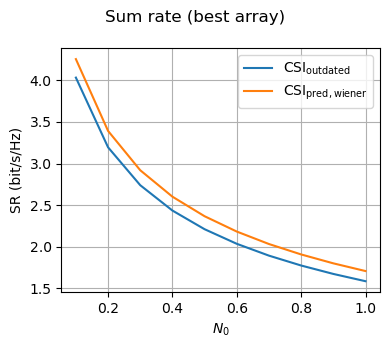

<Figure size 640x480 with 0 Axes>

In [10]:
# Range of noise values
N_0_vector = np.linspace(0.1,1,10)

# Sum Rate per noise power for Outdated CSI
mean_sum_rate_per_N_0_outdated = []
for i in range(N_0_vector.shape[0]):
    sr = sum_rate(true_csi_freq_domain_test, outdated_csi_freq_domain_test, N_0 = N_0_vector[i])
    best_array_indices = select_best_array(true_csi_freq_domain_test, outdated_csi_freq_domain_test)
    sr_best = []
    for j in range(best_array_indices.shape[0]):
        sr_best.append(sr[j,best_array_indices[j]])
    sr_best = np.asarray(sr_best)
    mean_sum_rate_per_N_0_outdated.append(np.mean(sr_best))
mean_sum_rate_per_N_0_outdated = np.asarray(mean_sum_rate_per_N_0_outdated)

# Sum Rate per noise power for Predicted CSI (Wiener)
mean_sum_rate_per_N_0_wiener = []
for i in range(N_0_vector.shape[0]):
    sr = sum_rate(true_csi_freq_domain_test, predicted_csi_freq_domain_test_wiener, N_0 = N_0_vector[i])
    best_array_indices = select_best_array(true_csi_freq_domain_test, predicted_csi_freq_domain_test_wiener)
    sr_best = []
    for j in range(best_array_indices.shape[0]):
        sr_best.append(sr[j,best_array_indices[j]])
    sr_best = np.asarray(sr_best)
    mean_sum_rate_per_N_0_wiener.append(np.mean(sr_best))
mean_sum_rate_per_N_0_wiener = np.asarray(mean_sum_rate_per_N_0_wiener)

#Plot
fig = plt.subplots(figsize=(4,3.5))
plt.plot(N_0_vector, mean_sum_rate_per_N_0_outdated, label = "$\mathrm{CSI}_\mathrm{outdated}$")
plt.plot(N_0_vector, mean_sum_rate_per_N_0_wiener, label = "$\mathrm{CSI}_\mathrm{pred, wiener}$")
plt.xlabel("$N_0$")
plt.ylabel("SR (bit/s/Hz)")
plt.legend()
plt.grid()
plt.suptitle("Sum rate (best array)")
plt.tight_layout()
plt.show()
plt.clf()

## Plot sum rate per array

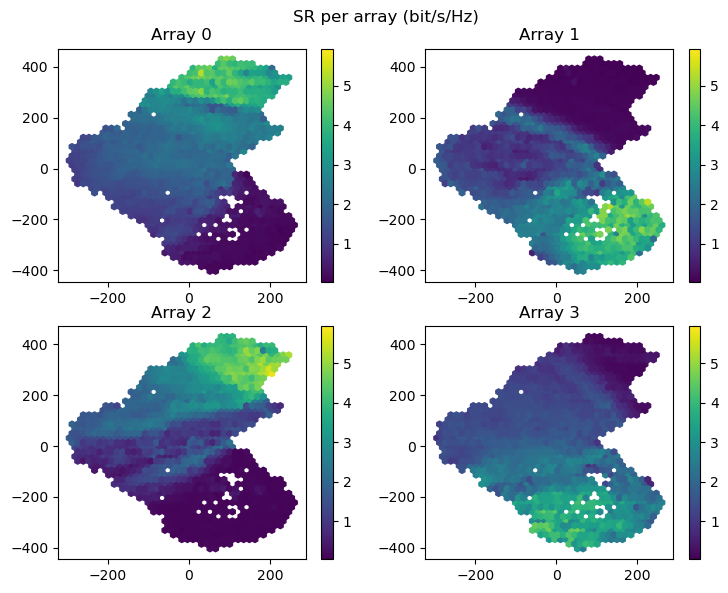

<Figure size 640x480 with 0 Axes>

In [11]:
# Scatter plot with coloring obtained by sum rate per datapoint
sr = sum_rate(true_csi_freq_domain_test, predicted_csi_freq_domain_test_wiener, N_0 = 0.35)

fig, axs = plt.subplots(2, 2, figsize=(7.5, 6))
fig.suptitle('SR per array (bit/s/Hz)')
fig.tight_layout()
vmin = sr.min()
vmax = sr.max()

# Array 0
axs[0, 0].hexbin(true_cc_positions_test[:, 0],
                  true_cc_positions_test[:, 1], 
                  gridsize=40, C=sr[:, 0], vmin=vmin, vmax=vmax)
axs[0, 0].set_title('Array 0')
fig.colorbar(axs[0, 0].collections[0], ax=axs[0, 0])
# Array 1
axs[0, 1].hexbin(true_cc_positions_test[:, 0],
                  true_cc_positions_test[:, 1], 
                  gridsize=40, C=sr[:, 1], vmin=vmin, vmax=vmax)
axs[0, 1].set_title('Array 1')
fig.colorbar(axs[0, 1].collections[0], ax=axs[0, 1])
# Array 2
axs[1, 0].hexbin(true_cc_positions_test[:, 0],
                  true_cc_positions_test[:, 1], 
                  gridsize=40, C=sr[:, 2], vmin=vmin, vmax=vmax)
axs[1, 0].set_title('Array 2')
fig.colorbar(axs[1, 0].collections[0], ax=axs[1, 0])
# Array 3
axs[1, 1].hexbin(true_cc_positions_test[:, 0],
                  true_cc_positions_test[:, 1], 
                  gridsize=40, C=sr[:, 3], vmin=vmin, vmax=vmax)
axs[1, 1].set_title('Array 3')
fig.colorbar(axs[1, 1].collections[0], ax=axs[1, 1])

plt.show()
plt.clf()

## Plot sum rate at best array

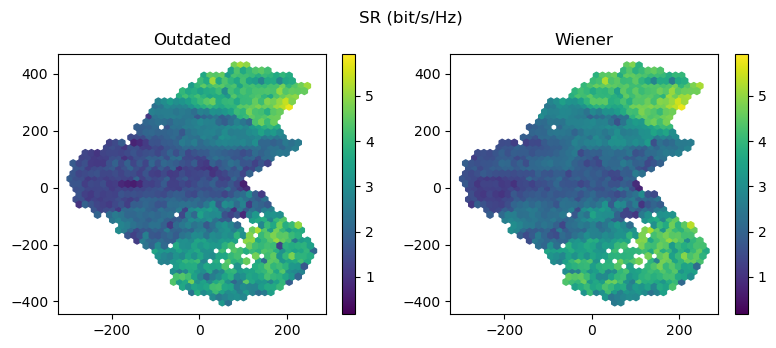

<Figure size 640x480 with 0 Axes>

In [12]:
# Scatter plot with coloring obtained by sum rate per datapoint

# Outdated
sr = sum_rate(true_csi_freq_domain_test, outdated_csi_freq_domain_test, N_0 = 0.35)

best_array_indices = select_best_array(true_csi_freq_domain_test, outdated_csi_freq_domain_test)
sr_best = []
for j in range(best_array_indices.shape[0]):
    sr_best.append(sr[j,best_array_indices[j]])
sr_best_outdated = np.asarray(sr_best)

# Wiener
sr = sum_rate(true_csi_freq_domain_test, predicted_csi_freq_domain_test_wiener, N_0 = 0.35)

best_array_indices = select_best_array(true_csi_freq_domain_test, predicted_csi_freq_domain_test_wiener)
sr_best = []
for j in range(best_array_indices.shape[0]):
    sr_best.append(sr[j,best_array_indices[j]])
sr_best_wiener = np.asarray(sr_best)

vmin = np.array([sr_best_outdated.min(),sr_best_wiener.min()]).min()
vmax = np.array([sr_best_outdated.max(),sr_best_wiener.max()]).max()

fig, axs = plt.subplots(1, 2, figsize=(8, 3.5))
fig.suptitle('SR (bit/s/Hz)')
fig.tight_layout()

# Outdated
axs[0].hexbin(true_cc_positions_test[:, 0],
                  true_cc_positions_test[:, 1], 
                  gridsize=40, C=sr_best_outdated, vmin=vmin, vmax=vmax)
axs[0].set_title('Outdated')
fig.colorbar(axs[0].collections[0], ax=axs[0])

# Wiener
axs[1].hexbin(true_cc_positions_test[:, 0],
                  true_cc_positions_test[:, 1], 
                  gridsize=40, C=sr_best_wiener, vmin=vmin, vmax=vmax)
axs[1].set_title('Wiener')
fig.colorbar(axs[1].collections[0], ax=axs[1])

plt.show()
plt.clf()

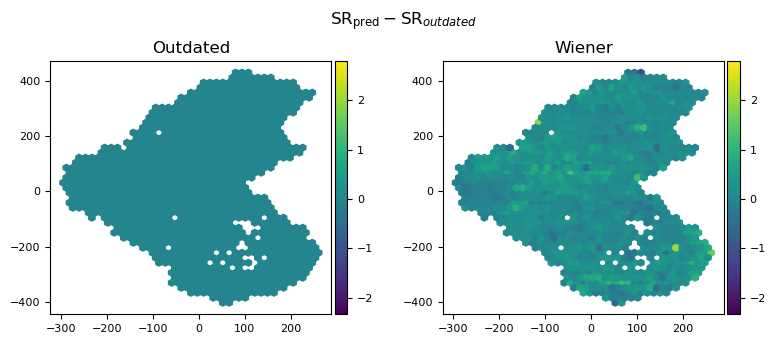

<Figure size 640x480 with 0 Axes>

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3.5))
fig.suptitle('$\mathrm{SR}_\mathrm{pred} - \mathrm{SR}_{outdated}$')
fig.tight_layout()

vmin = np.array([np.subtract(sr_best_wiener,sr_best_outdated).min()]).min()
vmax = np.array([np.subtract(sr_best_wiener,sr_best_outdated).max()]).max()

# Outdated
axs[0].hexbin(true_cc_positions_test[:, 0],
                  true_cc_positions_test[:, 1], 
                  gridsize=40, C=sr_best_outdated-sr_best_outdated, vmin=vmin, vmax=vmax)
axs[0].set_title('Outdated')
axs[0].tick_params(axis='both', labelsize=8)
cbar0 = fig.colorbar(axs[0].collections[0], ax=axs[0], pad = 0.01)
cbar0.ax.tick_params(labelsize=8)

# Wiener
axs[1].hexbin(true_cc_positions_test[:, 0],
                  true_cc_positions_test[:, 1], 
                  gridsize=40, C=sr_best_wiener-sr_best_outdated, vmin=vmin, vmax=vmax)
axs[1].set_title('Wiener')
axs[1].tick_params(axis='both', labelsize=8)
cbar1 = fig.colorbar(axs[1].collections[0], ax=axs[1], pad=0.01)
cbar1.ax.tick_params(labelsize=8)

plt.show()
plt.clf()